In [34]:
# Run once
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
!pip install --quiet transformers datasets accelerate sentencepiece --upgrade
!pip install --quiet tqdm scikit-learn matplotlib seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [35]:
# CSC396 - Intro to Deep Learning w/ NLP
# Claire Lynch & Jose Santiago Campa Morales
# Final Project
# Hate Speech and Offensive Language Classifier

# Imports
import os
import math
import random
from pathlib import Path
from dataclasses import dataclass
from typing import List, Dict, Any

import random
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm
from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoConfig,
    get_linear_schedule_with_warmup,
)
from transformers import logging as hf_logging

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForSequenceClassification

# enable tqdm in pandas
tqdm.pandas()

hf_logging.set_verbosity_error()  # reduce HF noise

# set to True to use the gpu (if there is one available)
use_gpu = True
# select device
device = torch.device('cuda' if use_gpu and torch.cuda.is_available() else 'cpu')
print(f'device: {device.type}')

# Model config:
MODEL_NAME = "roberta-base"
MAX_LENGTH = 128
BATCH_SIZE = 16
NUM_EPOCHS = 3
LR = 2e-5
WEIGHT_DECAY = 0.01
OUTPUT_DIR = Path("checkpoints/roberta_hateclf")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
SEED = 42

# random seed
seed = 1234

# set random seed
if seed is not None:
    print(f'random seed: {seed}')
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

device: cpu
random seed: 1234


In [36]:
# Cleaning text + emojis

import re
import html
import emoji

def normalize_repeated_chars(word):
    # Replace 3+ repeated characters with exactly 2 (e.g. "soooo" → "soo")
    return re.sub(r'(.)\1{2,}', r'\1\1', word)

def clean_tweet(tweet):
    # 1. Lowercase
    tweet = tweet.lower()

    # 2. Remove backslashes
    tweet = tweet.replace('\\', ' ')

    # 3. Decode HTML entities
    tweet = html.unescape(tweet)

    # 4. Remove URLs
    tweet = re.sub(r'http\S+|www\S+', '', tweet)

    # 5. Tokenize using the HF tokenizer (preserves subwords)
    tokens = tokenizer.tokenize(tweet)

    clean_tokens = []
    for t in tokens:
        # 6. Remove leading @
        if t.startswith('@'):
            t = t[1:]

        # 7. Remove leading #
        if t.startswith('#'):
            t = t[1:]

        # 8. Convert emojis into text
        if emoji.is_emoji(t):
            t = emoji.demojize(t)

        # 9. Remove unwanted characters
        t = re.sub(r'[^a-zA-Z0-9:]', '', t)

        # 10. Normalize repeated letters
        t = normalize_repeated_chars(t)

        # 11. Keep non-empty tokens
        if t:
            clean_tokens.append(t)

    return clean_tokens

Columns found: ['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither', 'class', 'tweet']


  0%|          | 0/24783 [00:00<?, ?it/s]

Loaded: data/labeled_data.csv
Label distribution (counts):
label
1    19190
2     4163
0     1430
Name: count, dtype: int64
   class                                               text  \
0      2  !!! RT @mayasolovely: As a woman you shouldn't...   
1      1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...   
2      1  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...   

                                              tokens  \
0  [r, t, may, as, ol, ove, ly, :, as, a, woman, ...   
1  [r, t, m, le, ew, 17, :, boy, d, ats, cold, ty...   
2  [r, t, ur, kind, of, brand, d, aw, g, r, t, 80...   

                                          clean_text          label_name  \
0  r t may as ol ove ly : as a woman you shouldn ...             neither   
1  r t m le ew 17 : boy d ats cold ty ga d wn bad...  offensive_language   
2  r t ur kind of brand d aw g r t 80 sb aby 4 li...  offensive_language   

   label  
0      2  
1      1  
2      1  
Split sizes: Train: 17347, Val: 2479, Test: 4957


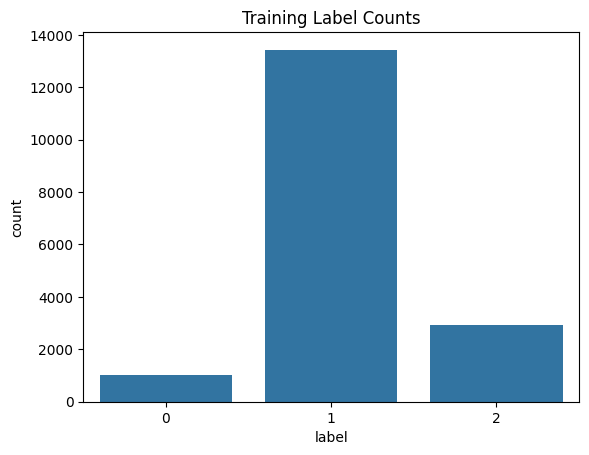

In [37]:
# Read dataset, clean, map labels, split
def read_data_df(filename, test_size=0.2, val_size=0.1, random_state=seed):
    """
    Read CSV and return train_df, val_df, test_df (plus extracted lists).
    Expects original columns including 'class' and 'tweet'.
    """
    df = pd.read_csv(filename)

    print("Columns found:", df.columns.tolist())   # DEBUG

    # Your dataset ALWAYS has these columns:
    # ['count', 'hate_speech', 'offensive_language', 'neither', 'class', 'tweet']

    # Keep only tweet + class
    df = df[['class', 'tweet']].copy()

    # Rename tweet -> text (CRUCIAL)
    df = df.rename(columns={'tweet': 'text'})

    # Clean tweets
    from tqdm.auto import tqdm
    tqdm.pandas()

    df['tokens'] = df['text'].progress_apply(clean_tweet)
    df['clean_text'] = df['tokens'].apply(lambda toks: " ".join(toks))

    # Map classes to labels
    label_map = {
        0: "hate_speech",
        1: "offensive_language",
        2: "neither"
    }
    df['label_name'] = df['class'].map(label_map)

    # numeric label column (0/1/2) used by model
    df['label'] = df['class'].astype(int)

    # rename tweet -> text (our pipeline expects 'text')
    df = df.rename(columns={'tweet': 'text'})

    # Show summary
    print("Loaded:", filename)
    print("Label distribution (counts):")
    print(df['label'].value_counts())
    print(df.head(3))

    # Now split: train / temp(test) then split train->train+val
    train_df, test_df = train_test_split(
        df,
        test_size=test_size,
        stratify=df['label'],
        random_state=random_state
    )

    # Now carve out val from the train_df (val_size fraction of original train)
    # compute val fraction relative to train_df:
    rel_val = val_size / (1.0 - test_size)
    train_df, val_df = train_test_split(
        train_df,
        test_size=rel_val,
        stratify=train_df['label'],
        random_state=random_state
    )

    print(f"Split sizes: Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
    print("\nTrain label distribution:")
    print(train_df['label'].value_counts())

    # also produce lists (used by tokenizer/dataset code)
    train_texts, train_labels = train_df['clean_text'].tolist(), train_df['label'].tolist()
    val_texts, val_labels = val_df['clean_text'].tolist(), val_df['label'].tolist()
    test_texts, test_labels = test_df['clean_text'].tolist(), test_df['label'].tolist()

    return train_df, val_df, test_df, (train_texts, train_labels, val_texts, val_labels, test_texts, test_labels)

file_path = "data/labeled_data.csv"
train_df, val_df, test_df, (train_texts, train_labels, val_texts, val_labels, test_texts, test_labels) = read_data_df(file_path)

sns.countplot(x=train_df['label'])
plt.title("Training Label Counts")
plt.show()

In [38]:
# Tokenizer + Dataset + Dataloaders

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class HFTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=MAX_LENGTH):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        # if there's an existing tokenize_texts function, use it (expects a single string)
        if 'tokenize_texts' in globals():
            enc = tokenize_texts(text, tokenizer=tokenizer, max_length=self.max_length)
            # tokenize_texts should return dict with input_ids, attention_mask
        elif 'tokenize' in globals():
            enc = tokenize(text, tokenizer=tokenizer, max_length=self.max_length)
        else:
            enc = tokenizer(
                text,
                padding='max_length',
                truncation=True,
                max_length=self.max_length,
            )
        enc_input_ids = torch.tensor(enc['input_ids'], dtype=torch.long)
        enc_attention_mask = torch.tensor(enc.get('attention_mask', [1]*len(enc['input_ids'])), dtype=torch.long)
        label = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return {'input_ids': enc_input_ids, 'attention_mask': enc_attention_mask, 'labels': label}

# Collate fn: use tokenizer.pad for dynamic padding (safer)
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = torch.stack([item['labels'] for item in batch])
    batch_enc = tokenizer.pad(
        {'input_ids': input_ids, 'attention_mask': attention_mask},
        padding='longest',
        return_tensors='pt'
    )
    batch_enc['labels'] = labels
    return batch_enc

# create datasets
train_dataset = HFTextDataset(train_texts, train_labels, tokenizer, max_length=MAX_LENGTH)
val_dataset = HFTextDataset(val_texts, val_labels, tokenizer, max_length=MAX_LENGTH)
test_dataset = HFTextDataset(test_texts, test_labels, tokenizer, max_length=MAX_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print("Dataloaders ready: train/val/test sizes:", len(train_dataset), len(val_dataset), len(test_dataset))

Dataloaders ready: train/val/test sizes: 17347 2479 4957


In [39]:
# Model + training loop
num_labels = len(sorted(set(train_labels)))
print("Num labels:", num_labels)

config = AutoConfig.from_pretrained(MODEL_NAME, num_labels=num_labels, finetuning_task="classification")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)
model.to(device)

# optimizer + scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
total_steps = len(train_loader) * NUM_EPOCHS
warmup_steps = max(1, int(0.06 * total_steps))
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

# Optionally enable mixed precision if available (requires accelerate or torch.cuda.amp)
use_amp = torch.cuda.is_available()
scaler = torch.cuda.amp.GradScaler() if use_amp else None

def save_checkpoint(epoch):
    path = OUTPUT_DIR / f"roberta_epoch{epoch}.pt"
    torch.save({
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'scheduler_state': scheduler.state_dict(),
    }, path)
    print("Saved checkpoint:", path)

# training
history = {'train_loss': [], 'val_loss': [], 'val_f1': []}

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    t_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Train E{epoch}", leave=True)
    for batch in pbar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        if use_amp:
            with torch.cuda.amp.autocast():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

        scheduler.step()
        t_loss += loss.item()
        pbar.set_postfix({'loss': f"{loss.item():.4f}"})

    avg_train_loss = t_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)
    print(f"Epoch {epoch} — avg train loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    v_loss = 0.0
    all_preds = []
    all_labels_eval = []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            v_loss += outputs.loss.item()
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds.tolist())
            all_labels_eval.extend(labels.cpu().numpy().tolist())

    avg_val_loss = v_loss / len(val_loader)
    history['val_loss'].append(avg_val_loss)
    p, r, f1, _ = precision_recall_fscore_support(all_labels_eval, all_preds, average='macro', zero_division=0)
    history['val_f1'].append(f1)
    print(f"Epoch {epoch} — val_loss: {avg_val_loss:.4f} — val_macro_f1: {f1:.4f}")

    save_checkpoint(epoch)


Num labels: 3


Train E1:   0%|          | 0/1085 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Test evaluation + report + confusion matrix
model.eval()
all_preds = []
all_labels_eval = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds.tolist())
        all_labels_eval.extend(labels.cpu().numpy().tolist())

print(classification_report(all_labels_eval, all_preds, digits=4, zero_division=0, target_names=[str(i) for i in range(num_labels)]))

cm = confusion_matrix(all_labels_eval, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(num_labels)], yticklabels=[str(i) for i in range(num_labels)])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix (test)')
plt.show()

if 'label_map' in globals():
    target_names = [label_map[i] for i in sorted(label_map.keys())]
    print(classification_report(all_labels_eval, all_preds, digits=4, zero_division=0, target_names=target_names))
